In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import utils
from data_statistical_features import Segment, SegmentStatistical

import os

# Load Data

In [2]:
df = pd.read_csv(utils.get_own_features_csv_path(10, 0.9, 10), index_col=False)

features = df.drop(Segment.get_feature_name_array(), axis='columns')
features['brueser_sqi'] = df['brueser_sqi']
features = features.replace()
features = features.fillna(0)
informative_inf = df[Segment.get_feature_name_array()]
target = df['informative']
patient_id = df['patient_id']
features_new = df.drop(SegmentStatistical.get_feature_name_array(), axis='columns')
features_new['brueser_sqi'] = df['brueser_sqi']
df_new = features_new.copy()
df_new['abs_err'] = df['abs_err']
df_new['rel_err'] = df['abs_err']
df_new['informative'] = df['informative']

In [18]:
df[df['rel_err'].isna()]

,brueser_sqi,patient_id,informative,ecg_hr,bcg_hr,abs_err,rel_err,minimum,maximum,mean,...,interval_lengths_std,interval_lengths_range,interval_lengths_mean,sqi_std,sqi_min,sqi_max,peak_max,peak_min,peak_mean,peak_min.1
541899,0.262410,5,True,NaN,70.588235,NaN,NaN,-1551.590684,2164.064087,-0.609809,...,45.900182,162.0,95.200000,0.068850,0.162793,0.385563,2164.063897,2164.063897,503.755528,2164.063897
541900,0.262492,5,True,NaN,70.588235,NaN,NaN,-1551.593554,2164.064676,-0.083041,...,41.759417,139.0,94.533333,0.068431,0.162793,0.385563,2164.063897,2164.063897,531.623990,2164.063897
541901,0.248965,5,True,NaN,70.588235,NaN,NaN,-1551.591953,2164.073931,-1.138322,...,41.642393,137.0,94.666667,0.072712,0.162793,0.385563,2164.063897,2164.063897,518.266949,2164.063897
541902,0.247662,5,True,NaN,68.965517,NaN,NaN,-1551.622761,2163.999191,1.909613,...,46.361574,137.0,103.733333,0.076728,0.162793,0.434869,2164.063897,2164.063897,542.660808,2164.063897
541903,0.250209,5,True,NaN,69.767442,NaN,NaN,-1551.514562,2164.010496,3.245871,...,47.785808,160.5,99.531250,0.073878,0.162793,0.434869,2164.063897,2164.063897,519.810469,2164.063897
541904,0.256342,5,True,NaN,69.767442,NaN,NaN,-1549.977517,2166.737017,0.670000,...,48.741107,160.5,101.433333,0.074242,0.162793,0.434869,2164.063897,2164.063897,529.362886,2164.063897
541905,0.269579,5,True,NaN,69.767442,NaN,NaN,-1499.681651,2156.621312,0.157004,...,48.367505,160.5,102.033333,0.083077,0.162793,0.434869,2164.063897,2164.063897,498.163059,2164.063897
541906,0.267323,5,True,NaN,67.039106,NaN,NaN,-1487.077323,2155.297309,2.091127,...,47.203422,160.5,104.406250,0.084857,0.162793,0.434869,2164.063897,2164.063897,462.733026,2164.063897
541907,0.249995,5,True,NaN,64.516129,NaN,NaN,-783.797304,608.398891,-0.356212,...,45.476904,158.5,103.794118,0.081920,0.144419,0.434869,646.461928,646.461928,318.437774,646.461928
541908,0.255789,5,True,NaN,64.516129,NaN,NaN,-784.522982,609.085644,0.798642,...,45.529602,158.5,106.264706,0.080547,0.144419,0.434869,598.754318,598.754318,289.015857,598.754318


# Correlation Heatmap

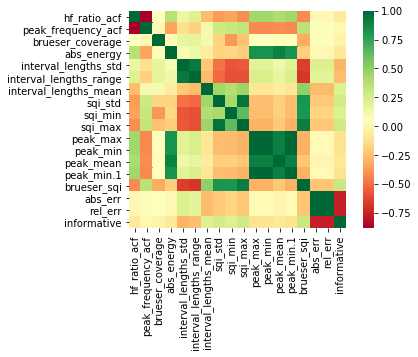

In [3]:
sns.heatmap(df_new.corr(), square=True, cmap ="RdYlGn")

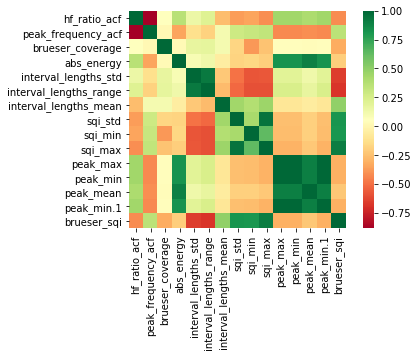

In [4]:
sns.heatmap(features_new.corr(), square=True, cmap ="RdYlGn")

# Paarweise geplottet

/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


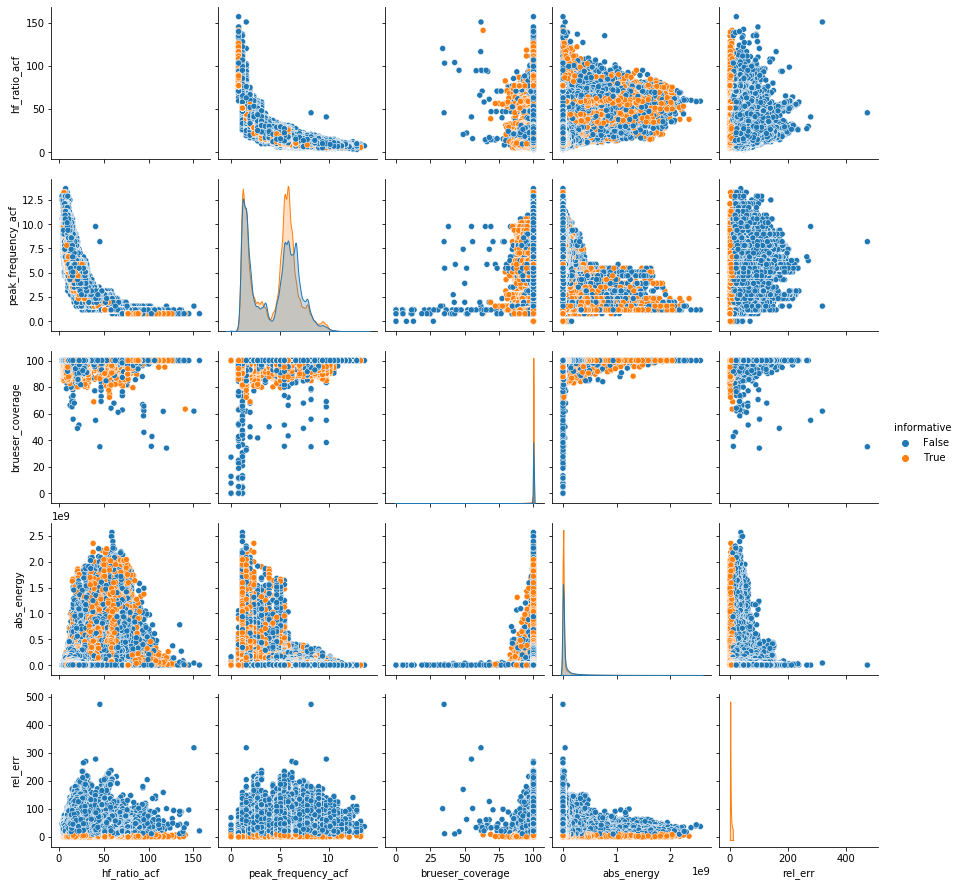

In [4]:
cols = ['hf_ratio_acf', 'peak_frequency_acf', 'brueser_coverage', 'abs_energy', 'rel_err', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)


/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


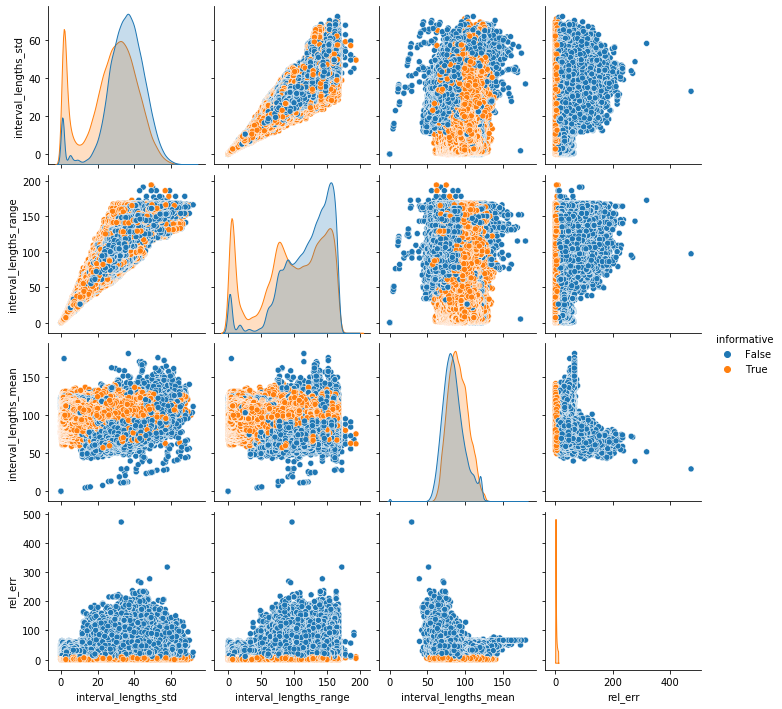

In [5]:
cols = ['interval_lengths_std', 'interval_lengths_range', 'interval_lengths_mean', 'rel_err', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)


/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


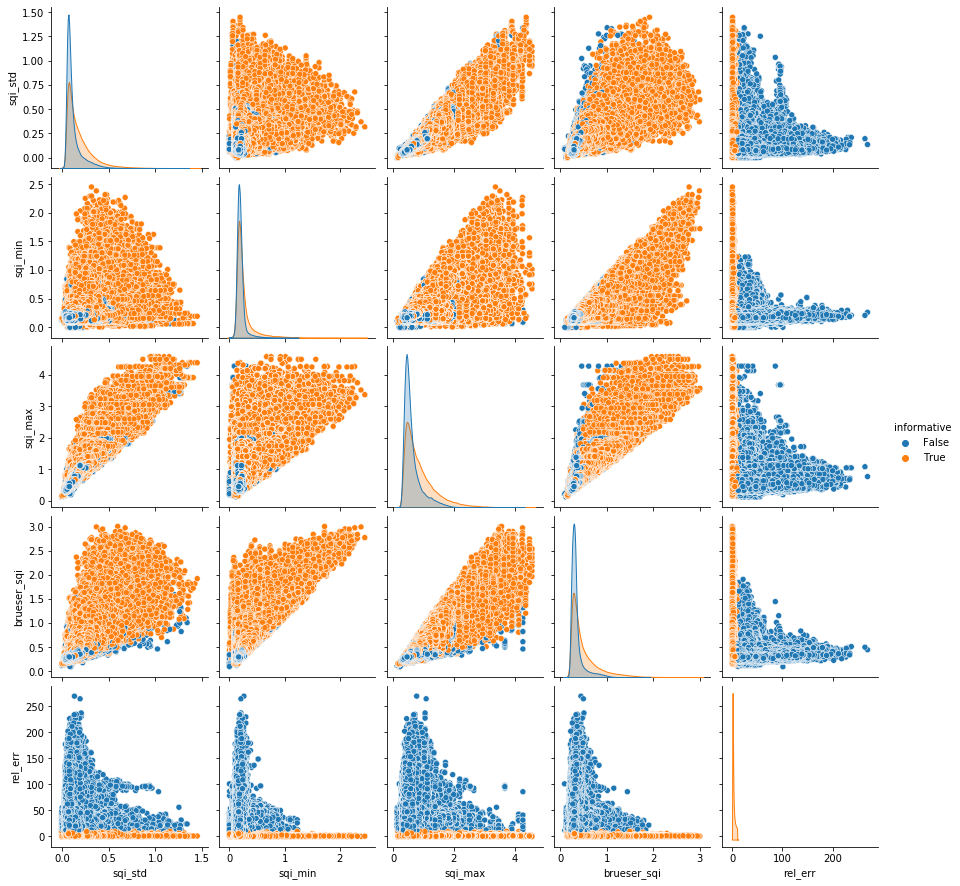

In [6]:
cols = ['sqi_std', 'sqi_min', 'sqi_max', 'brueser_sqi', 'rel_err', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

/Users/zianor/.virtualenvs/venv/Bachelorarbeit/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


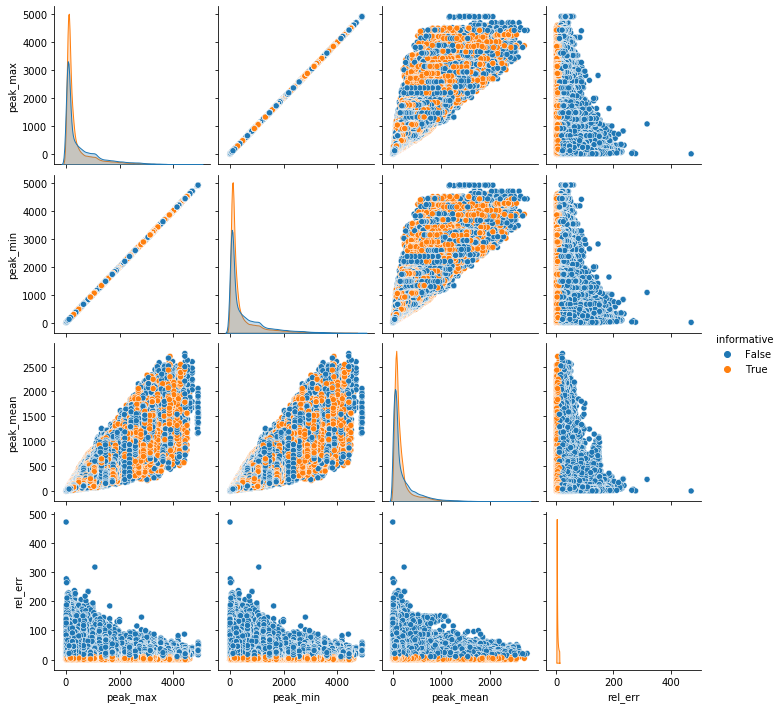

In [7]:
cols = ['peak_max','peak_min', 'peak_mean', 'rel_err', 'informative']
sns.pairplot(df[cols], kind='scatter', hue='informative', dropna=True)

# Boxplots features

# Einfluss der Merkmale bei Random Forest

In [3]:
from sklearn.ensemble import RandomForestClassifier


from ml_statistical_features import get_patient_split

In [4]:
forest = RandomForestClassifier(random_state=1)
features = features.replace([np.inf, -np.inf], 0)


x_train, x_test, y_train, y_test, groups_train, groups_test = get_patient_split(features, target, patient_id, test_size=0.2)

# TODO: hf_ratio_acf prevent inf values
forest.fit(x_train.fillna(0), y_train)


RandomForestClassifier(random_state=1)

In [5]:
print("Trainings-Set: ", str(forest.score(x_train, y_train)))
print("Test-Set: ", str(forest.score(x_test, y_test)))

Trainings-Set:  0.9999957974246618
Test-Set:  0.6061551345127185


 1) hf_ratio_acf                   0.096699
 2) brueser_sqi                    0.074239
 3) interval_lengths_mean          0.071184
 4) interval_lengths_std           0.055829
 5) number_zero_crossings          0.050670
 6) peak_frequency_acf             0.050395
 7) sqi_std                        0.046646
 8) sqi_max                        0.045361
 9) interval_lengths_range         0.041777
10) sqi_min                        0.037167
11) iqr                            0.034057
12) mad                            0.033524
13) skewness                       0.031572
14) kurtosis                       0.029967
15) peak_mean                      0.029703
16) variance_local_maxima          0.027497
17) mean_signal_envelope           0.024637
18) variance_local_minima          0.024387
19) minimum                        0.024118
20) std                            0.023707
21) abs_energy                     0.023492
22) range                          0.022511
23) maximum                     

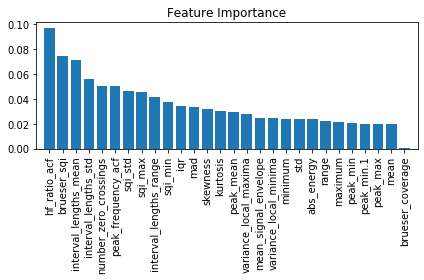

In [6]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, features.columns[indices[f]], importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]), importances[indices], align='center')
plt.xticks(range(x_train.shape[1]), features.columns[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.show()

In [7]:
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler

In [8]:
std_scaler = StandardScaler()

x_std = std_scaler.fit_transform(x_test)

In [ ]:
pca = KernelPCA(n_components=2)
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
pca = KernelPCA(n_components=2, kernel='cosine')
x_transform = pca.fit_transform(x_std)
df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

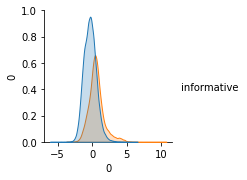

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

clf = LinearDiscriminantAnalysis(n_components=1)
clf.fit(x_std, y_test)
x_lda = clf.transform(x_std)
df_lda = pd.DataFrame(x_lda)
df_lda['informative'] = y_test.values

sns.pairplot(df_lda, kind='scatter', hue='informative')

In [ ]:
pca = KernelPCA(n_components=2, kernel='rbf')
x_transform = pca.fit_transform(x_std)

df = pd.DataFrame(x_transform)
df['informative'] = y_test.values

sns.pairplot(df, kind='scatter', hue='informative')

In [ ]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis

nca = NeighborhoodComponentsAnalysis(n_components=2)
x_nca = nca.fit_transform(x_std, y_test)

df_nca = pd.DataFrame(x_lda)
df_nca['informative'] = y_test.values

sns.pairplot(df_nca, kind='scatter', hue='informative')